# Notebook 2: Generate Features

The time series data itself is not suited for unsupervised learning methods such as clustering or dimensionality reduction. We first need to generate features which we can then use for subsequent analysis. There are many ways to generate features and each way has its advantages and disadvantages. There are three ways to represent the seismogram data:
1. calculate *hand-designed features* such as max amplitude or signal energy
2. calculate spectral or wavelet coefficients with Fourier or wavelet transform
3. use the latent space of unsupervised or self-supervised learning models (e.g. auto-encoders, contrastive learning)

While the first option provides maximal interpretability, it often fails at very complex tasks (e.g., capturing subtle differences between similar signals). The last options performs better at complex taks, but it often appears as a *black box*.

In this notebook we will focus on option 1 and 2. We will use *hand-designed features*, namely 4 time domain features (peak amplitude, signal energy, kurtosis, and skewness) and 4 spectral features (max freqeuncy, mean frequency, bandwidth, and spectral entropy). Besides that we calculate the power-spectral density coefficients. Later we can compare the dimensionality reduction and clustering results based on these two representations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
from matplotlib.mlab import psd
from scipy.signal.windows import tukey

## 2.1 Load and Prepare Data

In [2]:
WINDOW_LENGTH_SEC = 60  # length of the window in seconds 
OVERLAP_SEC = 30 # overlap between windows in seconds

In [3]:
stream = read("../example/stream.mseed")
data = stream[0].data
times = stream[0].times()
sampling_rate_hz = stream[0].stats.sampling_rate

In [4]:
# small function to cut the continuous data into segments
def cut_data(data, sampling_rate_hz, window_length_sec, overlap_sec):
    window_length = int(window_length_sec * sampling_rate_hz) # in samples
    overlap_length = int(overlap_sec * sampling_rate_hz) # in samples
    segments = [] # list to hold the segments
    num_segments = int((len(data) - window_length) / (window_length - overlap_length)) + 1 # number of segments
    # loop to cut the data into segments
    for i in range(num_segments):
        start = i * (window_length - overlap_length)
        end = start + window_length
        segment = data[start:end]
        segment -= np.mean(segment) # remove the mean
        segments.append(segment) # add the segment to the list
    return np.array(segments)

In [5]:
# apply function to cut data into segments
segments = cut_data(data, sampling_rate_hz, window_length_sec=WINDOW_LENGTH_SEC, overlap_sec=OVERLAP_SEC)

## 2.2 Calculate and Show Features

In [6]:
NORMALIZE = True # normalize the time series data
TAPER = True # apply a taper to the chunks of seismograms

In [7]:
# function to calculate features
def calculate_features(segments, normalize=True, taper=True):

    designed_features = [] # to store time domain and spectral features
    psd_features = [] # to store the power spectral density features

    # normalize the segments if required
    if normalize:
        segments = [segment / np.max(np.abs(segment)) for segment in segments]

    # iterate over each segment
    for segment in segments:
        
        # apply Tukey window if required
        if taper:
            window = tukey(len(segment), alpha=0.1)
            segment = segment * window

        # calculate time domain features
        peak_amplitude = np.max(np.abs(segment)) # same units as the data
        skewness = np.mean((segment / np.std(segment)) ** 3) # unitless
        kurtosis = np.mean((segment / np.std(segment)) ** 4) - 3 # unitless
        energy = np.sum(segment ** 2) # same units as the data squared

        # calculate spectral features (mean frequency, max frequency, variance)
        psd_values, freqs = psd(segment, NFFT=256, Fs=sampling_rate_hz, noverlap=128, scale_by_freq=True)
        psd_values_db = 10 * np.log10(psd_values) # convert to dB
        mean_freq = np.sum(freqs * psd_values) / np.sum(psd_values) # mean frequency in Hz
        max_freq = freqs[np.argmax(psd_values)] # frequency of the peak in the PSD in Hz
        bandwidth = np.sqrt(np.sum(((freqs - mean_freq)**2) * psd_values) / np.sum(psd_values)) # bandwidth in Hz
        spectral_entropy = -np.sum((psd_values / np.sum(psd_values)) * np.log(psd_values / np.sum(psd_values) + 1e-12)) # unitless

        # store features in the lists
        designed_features.append([peak_amplitude, skewness, kurtosis, energy, mean_freq, max_freq, bandwidth, spectral_entropy])
        psd_features.append(psd_values_db)

    # convert lists to numpy arrays
    designed_features = np.array(designed_features)
    psd_features = np.array(psd_features)

    return designed_features, psd_features, freqs

In [8]:
designed_features, psd_features, freqs = calculate_features(segments, normalize=NORMALIZE, taper=TAPER)
timestamps_features = np.arange(len(designed_features)) * 60 / 3600 # in hours

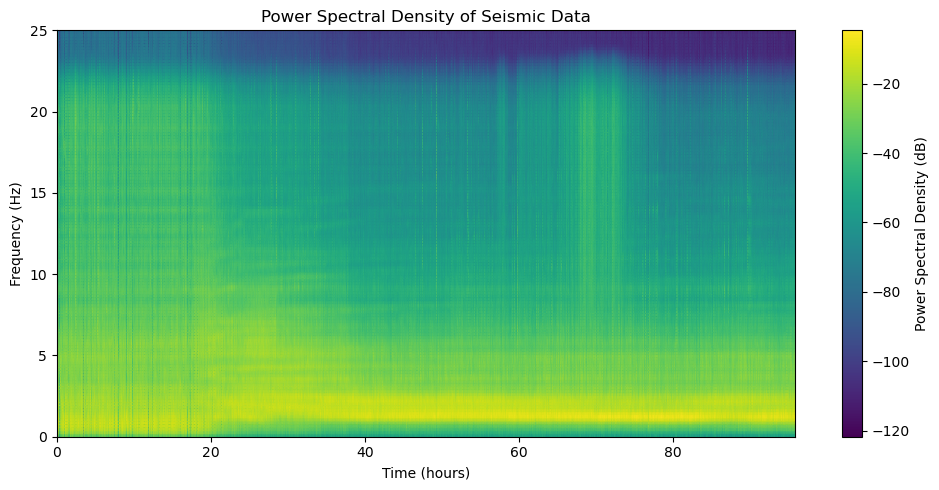

In [9]:
# show the power spectral density features
plt.figure(figsize=(10, 5))
plt.pcolormesh(timestamps_features, freqs, psd_features.T, shading='gouraud')
plt.colorbar(label='Power Spectral Density (dB)')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Spectral Density of Seismic Data')
plt.tight_layout()

Text(0, 0.5, 'Spectral Entropy')

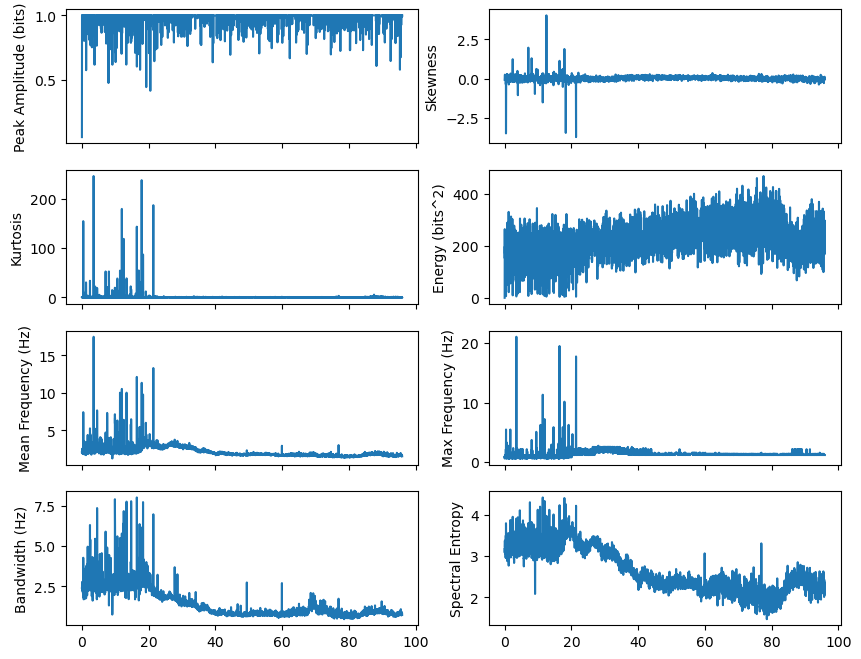

In [10]:
# show time domain and spectral features
fig, ax = plt.subplots(4, 2, figsize=(10, 8), sharex=True)
ax[0, 0].plot(timestamps_features, designed_features[:, 0], label="Peak Amplitude")
ax[0, 0].set_ylabel("Peak Amplitude (bits)")
ax[0, 1].plot(timestamps_features, designed_features[:, 1], label="Skewness")
ax[0, 1].set_ylabel("Skewness")
ax[1, 0].plot(timestamps_features, designed_features[:, 2], label="Kurtosis")
ax[1, 0].set_ylabel("Kurtosis")
ax[1, 1].plot(timestamps_features, designed_features[:, 3], label="Energy")
ax[1, 1].set_ylabel("Energy (bits^2)")
ax[2, 0].plot(timestamps_features, designed_features[:, 4], label="Mean Frequency (Hz)")
ax[2, 0].set_ylabel("Mean Frequency (Hz)")
ax[2, 1].plot(timestamps_features, designed_features[:, 5], label="Max Frequency (Hz)")
ax[2, 1].set_ylabel("Max Frequency (Hz)")
ax[3, 0].plot(timestamps_features, designed_features[:, 6], label="Bandwidth")
ax[3, 0].set_ylabel("Bandwidth (Hz)")
ax[3, 1].plot(timestamps_features, designed_features[:, 7], label="Spectral Entropy")
ax[3, 1].set_ylabel("Spectral Entropy")

We visualized the 8 time domain and spectral features as a time series. Are there any features which indicate gradual or aprubt changes? Do some features correlate or do we have redundant information?

## 2.3 Store the features for following notebooks

In [11]:
# save the features as numpy array
np.savez(
    "../example/features.npz",
    designed_features=designed_features,
    psd_features=psd_features,
    timestamps_features=timestamps_features,
    psd_freqs=freqs
    )